# CIFAR 100 Image Classification
This dataset contains 100 different classes of image. Each classes contain 500 images. All images are of 3 channels and of dimensions 32 x 32 . We will be applying different Deep Learning approaches to get the best outputs from this dataset.

1. Data Augmentation
2. Data Normalisation
3. Training On GPU
4. Learning rate scheduling : One Cycle Learning rate policy
5. Weight Decay
6. Adam & SGD Optimizers


The Source of the data set is from Kaggle. I would also like to thank Jovian.ml team and Aakash N S(Founder of Jovian.ml) for whom this project and this course on Deep Learnig with pytorch was possible . I am doing this Project with the help of the notebooks and course material provided in the [Deep Learning with pytorch : Zero To Gans](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans) course. This course is uploaded in You Tube for Free in freecodecamp.org YouTube Channel.

#Import all the required Libraries

In [123]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import opendatasets as od

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
# Torch Utilities
from torch.utils.data import DataLoader, random_split

#Torchvision
import torchvision
import torchvision.transforms as tt

#Torchvision Utils
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder


We will download the CFAR100 images in PNG format from the website https://fast.ai/Dataserts 

In [7]:
URL = "https://www.kaggle.com/minbavel/cifar-100-images"

od.download(URL)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhemakumar
Your Kaggle Key: ··········


  0%|          | 0.00/140M [00:00<?, ?B/s]

100%|██████████| 140M/140M [00:01<00:00, 88.8MB/s]


In [8]:
project_name = 'my-project-cifar100'

In [9]:
# Data folder structure viz & Classes
data_directory = './cifar-100-images/CIFAR100/'
print('Data Folders: ', os.listdir(data_directory))
print('Classes: ', os.listdir(data_directory + '/TRAIN'))

Data Folders:  ['TEST', 'TRAIN']
Classes:  ['mushroom', 'crocodile', 'beaver', 'butterfly', 'cloud', 'fox', 'tractor', 'cattle', 'beetle', 'hamster', 'rocket', 'shrew', 'elephant', 'aquarium_fish', 'shark', 'whale', 'table', 'baby', 'chair', 'skyscraper', 'mouse', 'girl', 'train', 'lamp', 'streetcar', 'plate', 'orange', 'lobster', 'leopard', 'bridge', 'wolf', 'castle', 'man', 'crab', 'camel', 'tank', 'poppy', 'maple_tree', 'oak_tree', 'keyboard', 'house', 'ray', 'telephone', 'trout', 'pine_tree', 'lion', 'woman', 'spider', 'rose', 'motorcycle', 'bowl', 'lawn_mower', 'caterpillar', 'dolphin', 'bed', 'tulip', 'seal', 'porcupine', 'bee', 'apple', 'clock', 'snail', 'rabbit', 'bus', 'can', 'mountain', 'sweet_pepper', 'dinosaur', 'snake', 'wardrobe', 'tiger', 'cup', 'kangaroo', 'road', 'chimpanzee', 'turtle', 'otter', 'sea', 'willow_tree', 'television', 'forest', 'bottle', 'flatfish', 'couch', 'plain', 'bear', 'palm_tree', 'lizard', 'cockroach', 'orchid', 'possum', 'worm', 'sunflower', 'racc

In [10]:
# Function for counting the images in each classe
def class_count(dataset, classes):

  classes_len = len(classes)
  count_dict = {} # initiate the dictionary to hold the count of elements in each class
  final_dict = {}
  for key in range(classes_len): # insert labels from classes and assign zero
    count_dict[key]=0
  for _, label in dataset: # iterate throught the dataset and increment the class count for each corresponding element found
    count_dict[label] +=1
  for i in range(classes_len):
    final_dict[classes[i]] = count_dict[i]
  return final_dict

In [11]:
dataset = ImageFolder(data_directory + 'TRAIN', transform = ToTensor())
Classes = dataset.classes

In [12]:
class_count(dataset, Classes)

{'apple': 500,
 'aquarium_fish': 500,
 'baby': 500,
 'bear': 500,
 'beaver': 500,
 'bed': 500,
 'bee': 500,
 'beetle': 500,
 'bicycle': 500,
 'bottle': 500,
 'bowl': 500,
 'boy': 500,
 'bridge': 500,
 'bus': 500,
 'butterfly': 500,
 'camel': 500,
 'can': 500,
 'castle': 500,
 'caterpillar': 500,
 'cattle': 500,
 'chair': 500,
 'chimpanzee': 500,
 'clock': 500,
 'cloud': 500,
 'cockroach': 500,
 'couch': 500,
 'crab': 500,
 'crocodile': 500,
 'cup': 500,
 'dinosaur': 500,
 'dolphin': 500,
 'elephant': 500,
 'flatfish': 500,
 'forest': 500,
 'fox': 500,
 'girl': 500,
 'hamster': 500,
 'house': 500,
 'kangaroo': 500,
 'keyboard': 500,
 'lamp': 500,
 'lawn_mower': 500,
 'leopard': 500,
 'lion': 500,
 'lizard': 500,
 'lobster': 500,
 'man': 500,
 'maple_tree': 500,
 'motorcycle': 500,
 'mountain': 500,
 'mouse': 500,
 'mushroom': 500,
 'oak_tree': 500,
 'orange': 500,
 'orchid': 500,
 'otter': 500,
 'palm_tree': 500,
 'pear': 500,
 'pickup_truck': 500,
 'pine_tree': 500,
 'plain': 500,
 'pl

# Data Normalization & Augmentation

1. Channel-wise data Normalization


2. Data augmentation

In [13]:
# Function to get mean and standard deviation of all the channels of the data
def get_mean_std(dataset):

  # create batches of data
  data_loader = DataLoader(dataset,batch_size = 128)

  channel_sum, channel_squared_sum, num_batches = 0, 0, 0
  #loop to process data in batches
  for data,_ in data_loader:
    channel_sum += torch.mean(data, dim = [0,2,3])
    channel_squared_sum += torch.mean(data**2, dim = [0, 2, 3])
    num_batches +=1
  
  # VAR[X] = E[X**2] - E[X]**2
  # STD[X] = sqrt(VAR[X])

  mean = channel_sum/num_batches
  std = (channel_squared_sum/num_batches-mean**2)**0.5
  # transform to numpy array
  mean = mean.numpy()
  std = std.numpy()
  return mean, std


In [14]:
mean, std = get_mean_std(dataset)

In [15]:
# converting mean/std into a tuples and save in stats tuple variable
t_mean = tuple(mean)
t_std = tuple(std)
stats = (t_mean, t_std)
stats

((0.5070937, 0.48655552, 0.44092253), (0.26733243, 0.256427, 0.27613324))

In [16]:
img, label = dataset[2500]

print('Shape: ', img.shape)
print('label: ', Classes[label])

Shape:  torch.Size([3, 32, 32])
label:  bed


In [17]:
def show_example(img, label):
  print('Shape: ', img.shape)
  print('label: ', Classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1,2,0))

Shape:  torch.Size([3, 32, 32])
label:  bed (5)


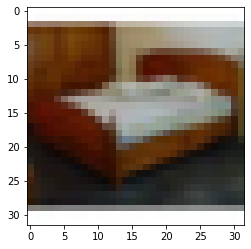

In [18]:
show_example(*dataset[2500])

Shape:  torch.Size([3, 32, 32])
label:  train (90)


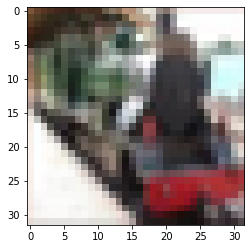

In [19]:
show_example(*dataset[45000])

In [20]:
#save and upload the notebook

!pip install jovian --upgrade -q
import jovian
jovian.commit(project=project_name)


[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/dhema100/my-project-cifar100


'https://jovian.ai/dhema100/my-project-cifar100'

#Training & Validation Datasets

The training dataset contains 50K images and we will be using the TEST data folder for validation purposes.

In [21]:
# Set Random seed

random_seed = 42 # random seed number fixed to have similar resets each time we run the notebook
torch.manual_seed(random_seed)

In [22]:
# Transformations for Dataset (Augmentation & Normalization)

train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats, inplace=True)])

In [23]:
# Data is now stored to ImageFolder instances after the above defined transformations
training_data = ImageFolder(data_directory+'TRAIN', train_tfms)
validation_data = ImageFolder(data_directory+'TEST', valid_tfms)

In [24]:
#Set the batch size parameter

batch_size = 400

In [25]:
# Data loaders for getting a specified batch size
training_dl = DataLoader(training_data, batch_size = batch_size, shuffle= True, num_workers =4, pin_memory=True)
validation_dl = DataLoader(validation_data,batch_size = batch_size*2, num_workers=4, pin_memory=True )

In [26]:
# Function to view the denormalized image (Since the images are normalised based on the 'stats' data)

def denormalize(image, mean, std):
  means = torch.tensor(mean).reshape(1,3,1,1) 
  stds = torch.tensor(std).reshape(1,3,1,1)
  #denormalized image
  d_image = image*stds + means
  return d_image

def show_batch(data_batch):


  for image, _ in data_batch:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_image = denormalize(image,*stats)
    ax.imshow(make_grid(denorm_image[:64],nrow=8).permute(1,2,0).clamp(0,1))
    break

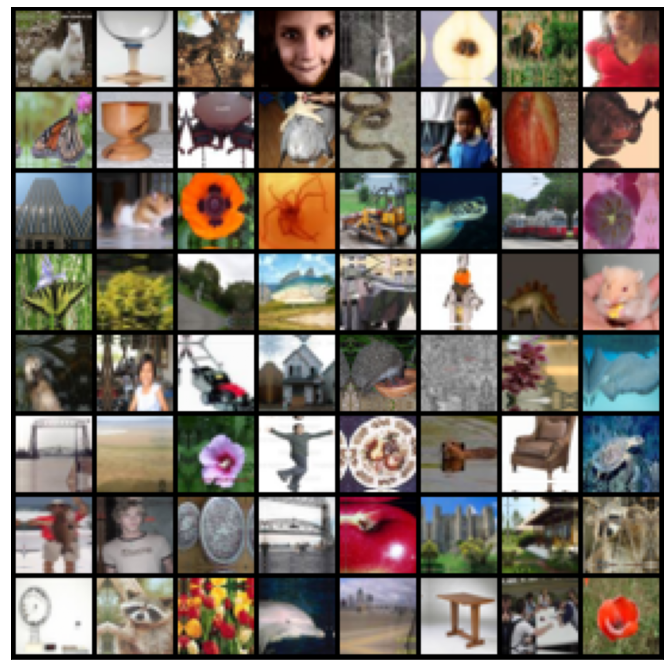

In [27]:
# Denormalised Images
show_batch(training_dl)

In [28]:
# Normalized Images
# Print the batch of images

def print_batch(dataloader):

  for batch_images, bacth_labels in dataloader:

    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(batch_images[:64], nrow = 8).permute(1,2,0))
    break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


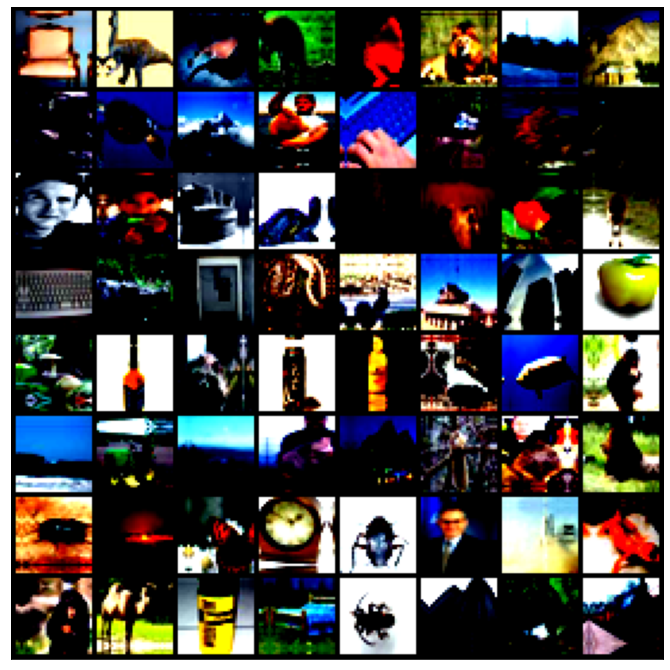

In [29]:
#transformed Images
print_batch(training_dl)

#Defining The Model

Creating a ImageClassification base class for handling the output logging and loss functions

In [30]:
class ImageClassificationBase(nn.Module):

  def training_step(self, batch): # calculate training loss
    images, labels = batch
    out = self(images) # Predictions of the model object whihc will be created subsequently in another class.
    loss = F.cross_entropy(out, labels) # calculate loss - using cross entropy loss function
    return loss

  def validation_step(self, batch): # calculate validation loss
    images, labels = batch
    out = self(images)                      #Generate Predictions
    val_loss = F.cross_entropy(out,labels)  # Calculate Loss
    val_accuracy = accuracy_fun(out, labels)    # calculate accuracy
    return {'batch_val_loss': val_loss.detach(), 'batch_val_acc': val_accuracy}

  def validation_epoch_end(self, outputs): # Calculate loss at the end of epoch
    batch_loss =  [X['batch_val_loss'] for X in outputs] # get the batch of validation losses
    epoch_loss =  torch.stack(batch_loss).mean() # calculate mean of the all batch losses to get epcoh loss
    batch_acc = [X['batch_val_acc'] for X in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'epoch_val_loss':epoch_loss,'epoch_val_acc':epoch_acc}
  
  def epoch_end(self, epoch, result):
    print('Epoch[{}], last_lr:{:.3f}, Train Loss:{:.2f}, Val Loss:{:.2f}, Val Acc:{:.2f}'.format(epoch,result['lrs'],result['epoch_train_loss'], result['epoch_val_loss'], result['epoch_val_acc']))

def accuracy_fun(outputs,labels):
  _, preds = torch.max(outputs, dim =1)
  return torch.sum(preds==labels)/len(preds)


CIFAR100 base class after extending the ImageClassificationBase class

In [111]:
def conv_block(in_channels, out_channels, pool = False): # Generalised convolution block
  layers = [
            nn.Conv2d(in_channels,out_channels, padding=1, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ELU(inplace=True)
            ]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)
def fcn_block(in_neuron, out_neuron, activation = True): # Generalised FCN(fully connected layer) block
  layers = [
            nn.BatchNorm1d(in_neuron),
            nn.Linear(in_neuron, out_neuron),
              ]
  if activation:
    layers.append(nn.ELU(inplace=True))

  return nn.Sequential(*layers)

# Custom Model
class Cifar100CnnModel(ImageClassificationBase):
  def __init__(self, in_channels, out_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels, 64) # out : 64 kernels(K), 32X32 (matrix dimension after passing the image)
    self.conv2 = conv_block(64,128, pool= True) # out : 128 K, 16X16
    self.res1  = nn.Sequential(conv_block(128,128), conv_block(128,128))
    self.conv3 = conv_block(128,256, pool = True) # out : 256 K, 8X8
    self.conv4 = conv_block(256,512, pool = True) # out : 512 K, 4X4
    self.res2  = nn.Sequential(conv_block(512,512), conv_block(512,512))
    self.conv5 = conv_block(512,1024, pool = True) # out : 1024 K, 2X2
    self.conv6 = conv_block(1024,1024,pool=True) # out : 1024 K, 1X1
    self.res3  = nn.Sequential(conv_block(1024,1024), conv_block(1024,1024))
    # FCN Layers
    self.fcn1 = fcn_block(1024,512) # FCN Layer 1
    self.fcn2 = fcn_block(512,256)  # FCN Layer 2
    self.outlayer = fcn_block(256,100,activation=False)   # Output Layer
   
    

  def forward(self,xb):
    # forward pass into Convolution layers
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out
    #out = self.classifier(out)
    
    # Flattening the output
    out = out.view(out.size(0),-1)
    # FCN
    out = self.fcn1(out)
    out = self.fcn2(out)
    out = self.outlayer(out)
    
    return out




# Movind Data To A GPU

In [35]:
# Get the default device
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [34]:
device = get_default_device()
device

device(type='cuda')

In [36]:
# Move data to default Device
def to_device(data, device):
  if isinstance(data, (list,tuple)):
   return [to_device(x, device) for x in data]
  return data.to(device,non_blocking=True)

In [37]:
for images, labels in training_dl:
  print(images.shape)
  print(images.device)
  images = to_device(images,device)
  print(images.device)
  break

torch.Size([400, 3, 32, 32])
cpu
cuda:0


In [38]:
class DeviceDataLoader():
  def __init__(self, data, device):
    self.data = data
    self.device = device

  def __iter__(self):
    for d in self.data:
      yield to_device(d, self.device)
    
  def __lens__(self):
    obj_len = len(self.data)
    return obj_len

In [39]:
training_dl = DeviceDataLoader(training_dl, device)
validation_dl = DeviceDataLoader(validation_dl, device)

In [40]:
for xb, yb in validation_dl:
  print(xb.device)
  print(yb.shape)
  break
  

cuda:0
torch.Size([800])


# Training The Model

We will define few functions to handle the training process and include the below regularization techniques

1. Learning rate scheduling : One Cycle Learning rate policy
2. Weight Decay
3. Dropout

To get the optimal learning rate, we will train the the model on one epoch with varying learning rate(increasing the lr by 5% per batch) and plot the loss function. We can then decide on the optimal learning rate

In [112]:
# 
@torch.no_grad()
def evaluate(model, validation_dl):
  model.eval() # flag for not calculating/updating the weights during evaluation phase
  outputs = [model.validation_step(valid_batch) for valid_batch in validation_dl]
  return model.validation_epoch_end(outputs)
def calculateFactor(lrMin, lrMax, n_steps):
  import math
  factor = math.exp(math.log(lrMax/lrMin)/n_steps)
  return round(factor,3)

def fitForOptimLR(model,epochs, training_dl, validation_dl,factor, optimizer= torch.optim.SGD, lr=1e-5 ):
  torch.cuda.empty_cache()
  optimizer_obj = optimizer(model.parameters(), lr)
  train_loss = []
  lrs = []
  history = []
  
  for epoch in range(epochs):
    model.train()
    # Training phase
    for batch in training_dl:
      # Generate predictions
      loss = model.training_step(batch)
      train_loss.append(loss)
      # Calculate Gradient and descend
      loss.backward()
      optimizer_obj.step()
      optimizer_obj.zero_grad()
      # lor LR and update
      lrs.append(lr)
      optimizer_obj.param_groups[0]['lr'] = optimizer_obj.param_groups[0]['lr']*factor
      lr = optimizer_obj.param_groups[0]['lr']

    # validation phase
    result = evaluate(model,validation_dl)
    result['epoch_train_loss'] = torch.stack(train_loss).mean().item()
    result['lrs'] = lrs[-1]
    model.epoch_end(epoch,result)
    history.append(result)
    return history, train_loss, lrs

In [113]:
# Set Params for finding the optimal learning rate
n_steps = training_dl.__lens__()
lrMin = 1e-5
lrMax = 1
factor = calculateFactor(lrMin,lrMax,n_steps)
print('Number of Steps:', n_steps)
print('Minimum Learning Rate: ', lrMin)
print('Maximum Learning Rate: ', lrMax)
print('Multiplication Factor: ', factor)

Number of Steps: 125
Minimum Learning Rate:  1e-05
Maximum Learning Rate:  1
Multiplication Factor:  1.096


In [55]:
model = to_device(Cifar100CnnModel(3,100),device)
model

Cifar100CnnModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [56]:
history = [evaluate(model,validation_dl)]
history

[{'epoch_val_acc': tensor(0.0122, device='cuda:0'),
  'epoch_val_loss': tensor(4.6055, device='cuda:0')}]

In [51]:
optimizer = torch.optim.SGD
epochs= 1

In [57]:
history, trainloss, lrs = fitForOptimLR(model,epochs, training_dl, validation_dl,factor, optimizer= optimizer, lr=lrMin )

Epoch[0], last_lr:0.864, Train Loss:4.41, Val Loss:107.28, Val Acc:0.02


Text(0, 0.5, 'Loss')

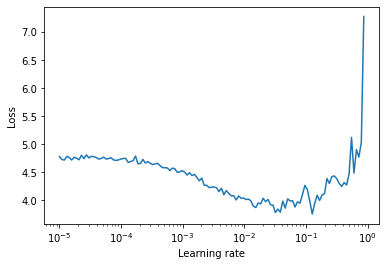

In [58]:
plt.plot(lrs, trainloss)
plt.gca().set_xscale('log')
plt.xlabel("Learning rate")
plt.ylabel("Loss")


As per the above observation, we can choose the max learning rate to be 1e-2 for the One cycle learning scehdule implementation

# Main Model

In [114]:
# Learning Rate getter

def get_lr(optimizer):
  lr = optimizer.param_groups[0]['lr']
  return lr

# Main Model
def one_cycle_fit(model, training_dl, validation_dl, epochs, max_lr, opt_func = torch.optim.SGD, weight_decay = 0):
  # Intitiate loops
  history = []
  # optimizer object
  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
  # one cycle scheduler
  oc_schedule = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch = n_steps)
  for epoch in range(epochs):
    model.train()
    train_loss = []
    lrs = []
    # Training
    for batch in training_dl:
      # Generate predictions
      loss = model.training_step(batch)
      train_loss.append(loss)
      # calculate Gradient
      loss.backward()
      # Gradient descent and set grad to zero
      optimizer.step()
      optimizer.zero_grad()

      # Log lr and update
      lrs.append(get_lr(optimizer))
      oc_schedule.step()

    # Validation
    result = evaluate(model,validation_dl)
    result['epoch_train_loss'] = torch.stack(train_loss).mean().item()
    result['lrs'] = lrs[-1]
    model.epoch_end(epoch,result)
    history.append(result)
  return history



In [74]:
# Setting Parameters

max_lr = 0.1
opt_func = torch.optim.SGD
weight_decay = 0
epochs = 15


In [75]:
train_history = [evaluate(model,validation_dl)]
train_history

[{'epoch_val_acc': tensor(0.5855, device='cuda:0'),
  'epoch_val_loss': tensor(1.4611, device='cuda:0')}]

# training The model

In [76]:
%%time
import time
start_time = time.time()

train_history += one_cycle_fit(model, training_dl, validation_dl, epochs, max_lr, opt_func= opt_func, weight_decay = weight_decay)
end_time = time.time()  

Epoch[0], last_lr:0.015, Train Loss:1.32, Val Loss:1.63, Val Acc:0.54
Epoch[1], last_lr:0.044, Train Loss:1.46, Val Loss:1.85, Val Acc:0.50
Epoch[2], last_lr:0.076, Train Loss:1.53, Val Loss:1.84, Val Acc:0.49
Epoch[3], last_lr:0.097, Train Loss:1.49, Val Loss:1.85, Val Acc:0.51
Epoch[4], last_lr:0.099, Train Loss:1.41, Val Loss:1.70, Val Acc:0.53
Epoch[5], last_lr:0.095, Train Loss:1.31, Val Loss:1.64, Val Acc:0.54
Epoch[6], last_lr:0.087, Train Loss:1.21, Val Loss:1.55, Val Acc:0.57
Epoch[7], last_lr:0.075, Train Loss:1.13, Val Loss:1.54, Val Acc:0.58
Epoch[8], last_lr:0.061, Train Loss:1.04, Val Loss:1.44, Val Acc:0.60
Epoch[9], last_lr:0.046, Train Loss:0.94, Val Loss:1.41, Val Acc:0.62
Epoch[10], last_lr:0.032, Train Loss:0.84, Val Loss:1.36, Val Acc:0.62
Epoch[11], last_lr:0.019, Train Loss:0.73, Val Loss:1.32, Val Acc:0.64
Epoch[12], last_lr:0.009, Train Loss:0.60, Val Loss:1.24, Val Acc:0.66
Epoch[13], last_lr:0.002, Train Loss:0.50, Val Loss:1.20, Val Acc:0.67
Epoch[14], last_

In [77]:
train_time=(end_time - start_time)/60
train_time

11.820313254992167

Validation Accuracy

In [78]:
def plot_val_accuracy(history):
  val_accuracy = [X['epoch_val_acc'] for X in history]
  plt.plot(val_accuracy,'-X')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');

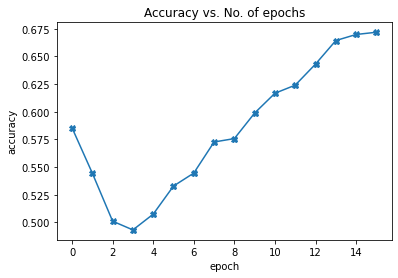

In [79]:
# For Model : model
plot_val_accuracy(train_history)

# Training & Validation Losses

In [80]:
def plot_losses(history):
    train_losses = [x.get('epoch_train_loss') for x in history]
    val_losses = [x['epoch_val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

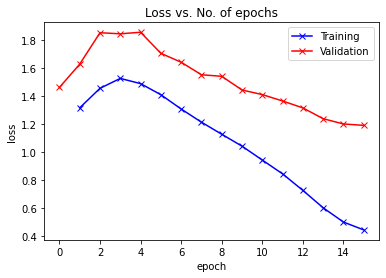

In [81]:
plot_losses(train_history)

Learning Rate VS Epoch

In [82]:
def plot_lrs(history):
    lrs = [x.get('lrs') for x in history]
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

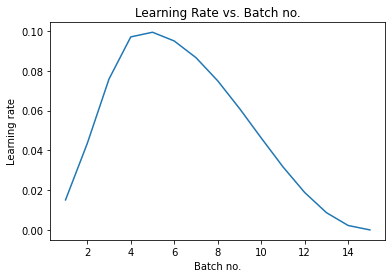

In [83]:
plot_lrs(train_history)

# Saving The Model

In [84]:
torch.save(model.state_dict(), 'cifar100-OneCycle.pth')

In [85]:
jovian.reset()
jovian.log_hyperparams(arch='custom', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle',
                       weight_decay=weight_decay,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [86]:
jovian.commit(project=project_name, environment=None, outputs=['cifar100-OneCycle.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (cifar100-OneCycle.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/dhema100/my-project-cifar100


'https://jovian.ai/dhema100/my-project-cifar100'

# Adam Optimization Model

In [120]:
model_adam = to_device(Cifar100CnnModel(3,100),device)
train_history_adam = [evaluate(model_adam,validation_dl)]
train_history_adam

[{'epoch_val_acc': tensor(0.0096, device='cuda:0'),
  'epoch_val_loss': tensor(4.6078, device='cuda:0')}]

In [121]:
opt_func_adam = torch.optim.Adam
epochs_adam = 20
max_lr_adam = 0.05
weight_decay_adam = 0

In [122]:
start_time_adam = time.time()
train_history_adam += one_cycle_fit(model_adam, training_dl, validation_dl, epochs_adam, max_lr_adam, opt_func= opt_func_adam , weight_decay = weight_decay_adam)
end_time_adam = time.time()
train_time_adam=(end_time_adam - start_time_adam)/60
train_time_adam

Epoch[0], last_lr:0.005, Train Loss:3.91, Val Loss:4.07, Val Acc:0.10
Epoch[1], last_lr:0.014, Train Loss:3.43, Val Loss:3.35, Val Acc:0.19
Epoch[2], last_lr:0.026, Train Loss:3.01, Val Loss:3.24, Val Acc:0.23
Epoch[3], last_lr:0.038, Train Loss:2.69, Val Loss:3.58, Val Acc:0.24
Epoch[4], last_lr:0.047, Train Loss:2.47, Val Loss:2.80, Val Acc:0.30
Epoch[5], last_lr:0.050, Train Loss:2.25, Val Loss:2.38, Val Acc:0.39
Epoch[6], last_lr:0.049, Train Loss:2.03, Val Loss:2.05, Val Acc:0.45
Epoch[7], last_lr:0.048, Train Loss:1.84, Val Loss:1.96, Val Acc:0.48
Epoch[8], last_lr:0.045, Train Loss:1.67, Val Loss:1.89, Val Acc:0.50
Epoch[9], last_lr:0.041, Train Loss:1.53, Val Loss:1.74, Val Acc:0.53
Epoch[10], last_lr:0.036, Train Loss:1.37, Val Loss:1.60, Val Acc:0.56
Epoch[11], last_lr:0.031, Train Loss:1.23, Val Loss:1.56, Val Acc:0.57
Epoch[12], last_lr:0.025, Train Loss:1.08, Val Loss:1.47, Val Acc:0.60
Epoch[13], last_lr:0.019, Train Loss:0.93, Val Loss:1.45, Val Acc:0.61
Epoch[14], last_

16.05734491745631

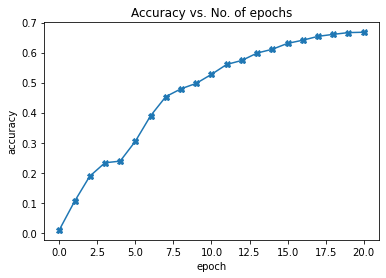

In [124]:
# For Model : model_adam
plot_val_accuracy(train_history_adam)


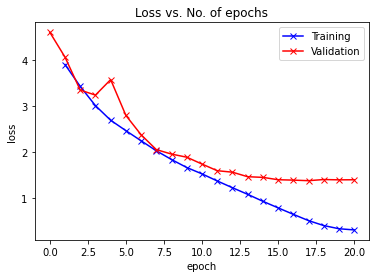

In [125]:
# For Model : model_adam
plot_losses(train_history_adam)

#Prediction

In [126]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return training_data.classes[preds[0].item()]

Label: apple , Predicted: apple


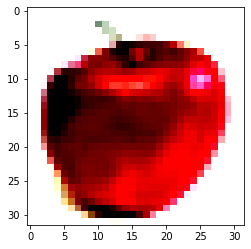

In [94]:
img, label = validation_data[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', training_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: apple , Predicted: apple


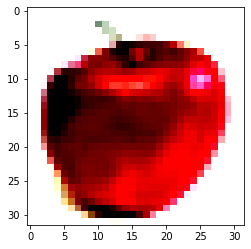

In [98]:
img, label = validation_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_data.classes[label], ', Predicted:', predict_image(img, model_adam))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bowl , Predicted: crab


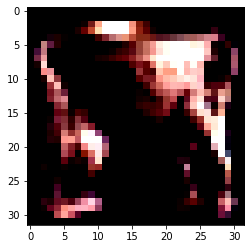

In [97]:
img, label = validation_data[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bowl , Predicted: crab


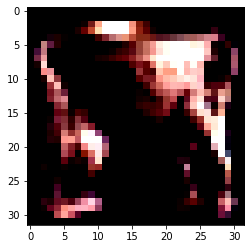

In [127]:
img, label = validation_data[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_data.classes[label], ', Predicted:', predict_image(img, model_adam))

# Commit

In [128]:
# Save Adam's model
torch.save(model.state_dict(), 'cifar100-adamOneCycle.pth')
jovian.reset()
jovian.log_hyperparams(arch='custom_adam', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       
                       opt=opt_func_adam.__name__)


[jovian] Hyperparams logged.


In [130]:
jovian.commit(project=project_name, environment=None, outputs=['cifar100-adamOneCycle.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (cifar100-adamOneCycle.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/dhema100/my-project-cifar100


'https://jovian.ai/dhema100/my-project-cifar100'